In [1]:
#Import paquetes a utilizar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import  *
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, dummy, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
import numpy as np
import math

In [3]:
#definicion del df
df_long = pd.read_csv('mensual_long.csv')

In [4]:
df_long.drop('Desc_Mes',1, inplace = True)

In [5]:
#Creacion de funcion para limpiar valores outliers de cada mes. 
def clean(mes_num):
    intqr = iqr(df_long['Precipitacions'][df_long['Mes'] == mes_num])
    q1 = df_long['Precipitacions'][df_long['Mes'] == mes_num].quantile(0.25)
    out_b = q1-(intqr*1.5)
    q3 = df_long['Precipitacions'][df_long['Mes'] == mes_num].quantile(0.75)
    out_a = q3 +(intqr*1.5)
    index = df_long[((df_long['Precipitacions'] > out_a) | (df_long['Precipitacions'] < out_b)) & (df_long['Mes'] == mes_num)].index
    return index

In [6]:
#Limpieza del df de outliers. 
for i in range(0,12):
    df_long.drop(clean(i), 0,inplace = True)

In [7]:
#Primer modelo de ML 
#Modelo de random forest regressor, regression para ver si se puede predecir la lluvia en funcion de los meses. 
X = df_long.drop(['Precipitacions', 'Any'], 1)
y = df_long['Precipitacions']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [9]:
Reg = RandomForestRegressor()
Reg.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
prediction_2 = Reg.predict(X_test)

In [11]:
Reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
#Metricas de evaluacion: 
print('R2 : ' + str(Reg.score(X_test, y_test)))
print('MSE : ' + str(mean_squared_error(y_test, prediction_2)))
print('MAE : ' + str(mean_absolute_error(y_test, prediction_2)))

R2 : 0.1330348440404544
MSE : 1242.4735025947837
MAE : 27.097766678364778


Las métricas indican un modelo deficiente con poca capacidad de predecir acuradamente el volumen de precipitacion segun los meses. 

Se lleva a cabo un Grid Search para ver si se puede mejorar el modelo. 

In [13]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features =  ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10,110, num = 11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [14]:
random_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features, 
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap
              }

In [15]:
rf_random = RandomizedSearchCV(estimator = Reg,
                              param_distributions = random_grid,
                              n_iter = 100, cv = 3, verbose = 2,
                              random_state = 45, n_jobs = -1)

In [16]:
search = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


In [17]:
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [18]:
rfr = RandomForestRegressor(n_estimators = 200,
     min_samples_split= 10,
     min_samples_leaf= 1,
     max_features= 'sqrt',
     max_depth= 80,
     bootstrap= True)

In [19]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_split=10,
                      n_estimators=200)

In [20]:
prediction = rfr.predict(X_test)

In [21]:
#Metricas de evaluacion: 
print('R2 : ' + str(rfr.score(X_test, y_test)))
print('MSE : ' + str(mean_squared_error(y_test, prediction)))
print('MAE : ' + str(mean_absolute_error(y_test, prediction)))

R2 : 0.13419109317559785
MSE : 1240.8164476336487
MAE : 27.091291459902813


Las métricas obtenidas son casi identicas a las anteriores. 

Como possible mejora se classifican los meses en funcion de la media de lluvia por mes siendo 1 el mes con menos lluvia i 12 el que mas 

In [ ]:
#Para aplicar regression ordenamos los meses en funcion de la media de lluvia por mes
#siendo 1 el mes con menos lluvia i 12 el que mas 
for i in range(1,13):
    print('mitjana mes: ' + str(i) + ('  ') + str(df_long['Precipitacions'][df_long['Mes'] == i].mean()))

In [23]:
dict_mesos = {1 : 3, 
              2 : 2 ,
              3 : 7,
              4 : 9, 
              5 : 8,
              6 : 4, 
              7 : 1, 
              8: 5, 
              9: 12 ,
              10 : 11 , 
              11: 10, 
              12 : 6}

In [24]:
df_long['Mes'] = df_long['Mes'].replace(dict_mesos)

In [25]:
X = df_long.drop('Precipitacions', 1)

In [26]:
y = df_long.Precipitacions

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [49]:
rfr = RandomForestRegressor(n_estimators = 200,
     min_samples_split= 10,
     min_samples_leaf= 1,
     max_features= 'sqrt',
     max_depth= 80,
     bootstrap= True)

In [50]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_split=10,
                      n_estimators=200)

In [51]:
prediction = rfr.predict(X_test)

In [58]:
print('R2 : ' + str(rfr.score(X_test, y_test)))
print('MSE : ' + str(mean_squared_error(y_test, prediction)))
print('RMSE :' +str(math.sqrt(mean_squared_error(y_test, prediction))))
print('MAE : ' + str(mean_absolute_error(y_test, prediction)))

R2 : 0.034747108417349515
MSE : 1906.1323283226018
RMSE :43.65927539850612
MAE : 31.34774277361666


Metricas han empeorado ligeramente respeto a las originales. 

Para ver de mejorar el estudio se hara añadiendo el datos de las temperaturas associadas a los meses. 

In [374]:
df_temp = pd.read_csv('temp_long.csv')

In [375]:
df_pluja = pd.read_csv('mensual_long.csv')

In [376]:
df_temp.drop(df_temp[df_temp['Any']<1786].index, axis = 0, inplace = True)

In [377]:
df = df_pluja.merge(df_temp)

In [378]:
df.drop(['Desc_Mes','Any'],1 ,inplace = True)

In [379]:
for i in range(0,12):
    df.drop(clean(i), 0,inplace = True)

In [380]:
df['Mes'].replace(dict_mesos, inplace = True)

In [382]:
df.to_csv('temp_pre.csv')

In [40]:
X = df.drop('Precipitacions', axis =1)
y = df.Precipitacions

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [60]:
Reg = RandomForestRegressor(n_estimators = 1000,
     min_samples_split= 10,
     min_samples_leaf= 4,
     max_features= 'sqrt',
     max_depth= 30,
     bootstrap= True)

In [61]:
Reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=1000)

In [62]:
prediction = Reg.predict(X_test)

In [63]:
print('R2 : ' + str(rfr.score(X_test, y_test)))
print('MSE : ' + str(mean_squared_error(y_test, prediction)))
print('MAE : ' + str(mean_absolute_error(y_test, prediction)))

R2 : 0.034747108417349515
MSE : 1802.9525598559896
MAE : 30.46465854380048


In [64]:
Reg.feature_importances_

array([0.36932475, 0.63067525])

In [67]:
#Prueba con un modelo de regression linear

In [68]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [71]:
prediction = model.predict(X_test)

In [73]:
print('R2 : ' + str(model.score(X_test, y_test)))
print('MSE : ' + str(mean_squared_error(y_test, prediction)))
print('MAE : ' + str(mean_absolute_error(y_test, prediction)))

R2 : 0.10924665271625744
MSE : 1759.0144164553667
MAE : 30.178629450379628


Metricas de avaulacion parecidas, no hemos conseguido un modelo de regession que sea capaz de predecir los valores de forma acertada. Aun y haber añadido la variable temperatura las métricas de los modelos son muy parecidas, la temperatura a ayudado a reducir los errores pero no a mejorar la capacidad de prediccion. 

Disenyo de modelo de classificación se classifican las medias mensuales segun altas o bajas si estan por debajo o por encima de la media del df y se hace un modelo que busque predecir en funcion del mes y de la temperatura su clasificacion. 

In [318]:
#Creamos df con precipitacions classificadas en las dos classes (0 debajo de media 1 encima de media)
df_clas = df.copy()

In [319]:
df_clas.reset_index(inplace = True, drop = True)

In [320]:
for i in range(len(df_clas)):
    if df_clas['Precipitacions'][i] < 44.9: 
        df_clas['Precipitacions'][i] = 0
    else: 
        df_clas['Precipitacions'][i] = 1

<ipython-input-320-422165509af3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clas['Precipitacions'][i] = 0
<ipython-input-320-422165509af3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clas['Precipitacions'][i] = 1


In [321]:
#Fem dummies per la variable mesos
dum = pd.get_dummies(df['Mes'], prefix = 'mes_')

In [322]:
df_dum = df_clas.join(dum)

In [323]:
df_dum.dropna(inplace = True)

In [324]:
df_dum.drop(['Mes'],1,inplace = True)

In [325]:
X = df_dum.drop('Precipitacions',1)
y = df_dum.Precipitacions

In [344]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [345]:
clf = RandomForestClassifier()

In [346]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [347]:
prediction = clf.predict(X_test)

In [348]:
print('Accuracy: ', accuracy_score(y_test, prediction))
print('f1_score: ', f1_score(y_test, prediction, average = 'weighted'))
print('recal_socre: ' ,recall_score(y_test, prediction, average = 'weighted'))

Accuracy:  0.5690072639225182
f1_score:  0.5618760528231258
recal_socre:  0.5690072639225182


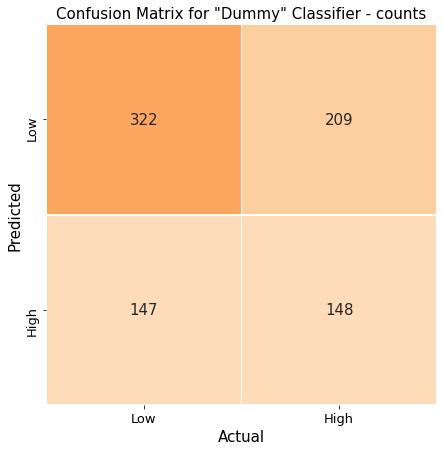

In [349]:
cm_logis = confusion_matrix(y_test, prediction)
#Put it into a df for sns plot function
cm_logis_df = pd.DataFrame(cm_logis)

#Use a sns heatmap to plot confusion matrices 
#The df is transposed to make actual values on x-axis and predicted on y-axis
fig, ax = plt.subplots(figsize = (7,7))
sns.heatmap(cm_logis_df.T, annot = True, annot_kws={'size':15}, cmap = 'Oranges', vmin = 0, vmax = 800, fmt = '.0f', 
           linewidths = 1, linecolor = 'white', cbar = False)
plt.ylabel('Predicted', fontsize = 15)
plt.xlabel('Actual', fontsize = 15)
ax.set_xticklabels(['Low', 'High'], fontsize = 13)
ax.set_yticklabels(['Low', 'High'], fontsize = 13)
plt.title('Confusion Matrix for "Dummy" Classifier - counts', fontsize = 15 )
plt.show()

In [340]:
clf.feature_importances_

array([0.94357869, 0.00393166, 0.00397738, 0.0037242 , 0.00912486,
       0.00402047, 0.00391455, 0.00477401, 0.0040584 , 0.00416128,
       0.00484312, 0.0036246 , 0.00626678])

Modelo poco concluyente, no se consigue predecir de forma acurada si el mes pertenece a la categoria de lluvias altas o bajas. Se deberia revisar la classificacion, para ver de que formas se puede hacer para aumentar la capacidad de prediccion. 

Con los modelos supervisado no se han encontrado patrones que expliquen las tendencias de lluvia ni a lo largo de los años ni en los distintos meses. Los modelos han obtenido una capacidad de prediccion poco superior a modelos aleatorios de prediccion. 